<a href="https://colab.research.google.com/github/ViacheslavCRBP/pythonProject/blob/master/HW_NLP_04_ViacheslavS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Задача тематическое моделирование

продолжаем исследование датасета с твитами

Скачиваем датасет ([источник](http://study.mokoron.com/)): [положительные](https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv?dl=0), [отрицательные](https://www.dropbox.com/s/r6u59ljhhjdg6j0/negative.csv).

или можно через ноутбук

!wget https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv
!wget https://www.dropbox.com/s/r6u59ljhhjdg6j0/negative.csv

как альтернатива можно скачать данные из Роспотребнадзора
https://zpp.rospotrebnadzor.ru/Forum/Appeals
для этого берём ноутбук `parse_rospotrebnadzor.ipynb`
устанавливаем количество скачанных страниц больше не 50-сят хотябы 500 и для анализа берём только вопросы так как ответы есть не всегда

что надо сделать
1. объединить в одну выборку (это только для твитов), для роспотребнадзора сформировать датасет из вопросов
2. провести исследование и выявить тематики о которых говорят в твитах (для твитов), а для роспотребнадзора так же выявить тематики о которых люди пишут проанализировать
3. сделать визуализацию кластеров тематик
4. проинтерпритировать получившиеся тематики

In [1]:
import requests
from bs4 import BeautifulSoup
import time
from urllib.parse import urlparse, urljoin
from tqdm.notebook import tqdm

In [2]:
## найти id каждого вопроса на страницах
page = 1
main_url = 'https://zpp.rospotrebnadzor.ru/Forum/Appeals/AjaxindexList?page={page}&searchtext=&categories=[]'

def ids_from_page(soup):
    return [i.get('href') for i  in soup.findAll('a', {'class':'appeal-title-link'})]

urls = []
for page in tqdm(range(1, 1000), desc='Pages'):
    time.sleep(0.5)
    res = requests.get(main_url.format(page=page))
    soup = BeautifulSoup(res.text)
    urls.extend(ids_from_page(soup))

Pages:   0%|          | 0/999 [00:00<?, ?it/s]

In [3]:
## имея id запросов достанем тексты на страницах
domain = 'https://zpp.rospotrebnadzor.ru'

def get_text_page_question(soup):
    return soup.findAll('p', {'class':'appeal-details-message'})[0].text
def get_text_page_answer(soup):
    return soup.findAll('p', {'class':'appeal-comments-message'})[0].text

question = []
answers = []

for url in tqdm(urls, desc='Pages'):
    time.sleep(0.5)
    res = requests.get(urljoin(domain, url))
    soup = BeautifulSoup(res.text)

    question.append(get_text_page_question(soup))
    try:
        answers.append(get_text_page_answer(soup))
    except:
        answers.append('No answer')

Pages:   0%|          | 0/4995 [00:00<?, ?it/s]

In [4]:
## посмотрим, что скачалось
N = 2
print('Q:', question[N])
print()
print('A:', answers[N])

Q: Здравствуйте. 04.12.23 заказал у мегамаркета телефон Samsung S23 Ultra на Мегамаркете у продавца Kosmostore за 105423 рубля. 08.12.23 получив посылку от курьера, я её вскрыл, а внутри лежит три куска мыла вместо смартфона. Сразу же всё отфотографировал и составил претензию на возврат денежных средств по причине несоответствия товара. Поддержка ответила быстро и предоставила мне видео упаковки смартфона от продавца. Изначально он там был. Далее поддержка признала факт кражи смартфона в логистике, упомянув, что таких обращений в тот день было целых 6(!) штук. На этом оператор поддержки отвечать мне перестал, а спустя 4 суток обращение закрыли с пометкой возврат не одобрен. Хочу вернуть средства или получить заказанный мною товар. 

A: Добрый день! Вами не указаны : область/город/село/район, адрес и организация ,оказывающая услугу. Управление Роспотребнадзора по Московской области не вправе рассматривать жалобы другого субъекта


In [5]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim.corpora import Dictionary
from gensim.models import LdaModel
import re
from tqdm.notebook import tqdm
from multiprocessing import Pool
from pymystem3 import Mystem



In [6]:
# Загрузка стоп-слов для русского языка
nltk.download('stopwords')
nltk.download('punkt')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [7]:
!pip install pymorphy2


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 60.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=eca774bfb2e38db49fac95912dfb5c5f510a915747faeab9b0e426eed7e1801f
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


In [8]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

In [9]:
!wget http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz
!tar -xvf mystem-3.1-linux-64bit.tar.gz
!mv mystem /usr/local/bin


--2023-12-13 15:26:48--  http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz
Resolving download.cdn.yandex.net (download.cdn.yandex.net)... 5.45.205.242, 5.45.205.243, 5.45.205.244, ...
Connecting to download.cdn.yandex.net (download.cdn.yandex.net)|5.45.205.242|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: http://cachev2-m9-8.cdn.yandex.net/download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz?lid=235 [following]
--2023-12-13 15:26:49--  http://cachev2-m9-8.cdn.yandex.net/download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz?lid=235
Resolving cachev2-m9-8.cdn.yandex.net (cachev2-m9-8.cdn.yandex.net)... 37.9.117.25, 2a02:6b8:c35:5:0:562:0:23
Connecting to cachev2-m9-8.cdn.yandex.net (cachev2-m9-8.cdn.yandex.net)|37.9.117.25|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 36635786 (35M) [application/octet-stream]
Saving to: ‘mystem-3.1-linux-64bit.tar.gz’

mystem-3.1-linux-64 100%[===================>

In [10]:
stopwords_list = set(stopwords.words('russian'))

# Инициализация лемматизатора
morph = pymorphy2.MorphAnalyzer()

# Регулярное выражение для поиска слов
words_regex = re.compile(r'\w+')

# def process_text(text, stopwords_list=stopwords_list, lemmer=morph):
#     # Приведение к нижнему регистру
#     text = text.lower()

#     # Токенизация и удаление стоп-слов и символов
#     tokens = words_regex.findall(text)
#     words = [word for word in tokens if word.isalpha() and len(word) >= 3 and word not in stopwords_list]

#     # Лемматизация
#     lemmas = [lemmer.parse(word)[0].normal_form for word in words]

#     return lemmas


def find_words(text, regex = words_regex):
    tokens =  regex.findall(text.lower())
    return [w for w in tokens if w.isalpha() and len(w) >= 3]


stopwords_list = stopwords.words('russian')

mystem = Mystem()
def lemmatize(words, lemmer = mystem, stopwords = stopwords_list):
    lemmas = lemmer.lemmatize(' '.join(words))
    return [w for w in lemmas if not w in stopwords
            and w.isalpha()]

# def lemmatize(words, lemmer = morph, stopwords = stopwords_list):
#     lemmas = [lemmer.parse(w)[0].normal_form for w in words]
#     return [w for w in lemmas if not w in stopwords
#             and w.isalpha()]

def process_text(text):
    return (lemmatize(find_words(text)))

Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz


In [11]:
# Обработка вопросов
preprocessed_questions = [process_text(text) for text in question]

# Пример обработки второго текста вопроса
print(preprocessed_questions[1])

['главный', 'врач', 'сэс', 'территориальный', 'отдел', 'роспотребнадзор', 'красноярский', 'край', 'лесосибирск', 'лесосибирск', 'красноярский', 'край', 'мир', 'телефон', 'mail', 'lesosibirsk', 'rospotrebnadzor', 'петрова', 'ольга', 'александровна', 'проживать', 'адрес', 'москва', 'перервинский', 'бульвар', 'корпус', 'тело', 'mail', 'rambler', 'просить', 'сообщать', 'проводить', 'возглавлять', 'сэс', 'санитарный', 'микробиологический', 'исследование', 'воздух', 'помещение', 'предмет', 'наличие', 'инфекционный', 'агент', 'условный', 'безусловный', 'патоген', 'бактерия', 'вирус', 'спор', 'грибок', 'плесень', 'кроме', 'просить', 'сообщать', 'стоимость', 'исследование', 'помещение', 'площадь', 'располагать', 'лесосибирск', 'этажный', 'панельный', 'многоквартирный', 'дом', 'ответ', 'просить', 'направлять', 'электронный', 'почта']


In [12]:
!pip install -U gensim
from gensim.models import *
from gensim import corpora

In [13]:
# Создание словаря и корпуса
dictionary = corpora.Dictionary(preprocessed_questions)

dictionary.filter_extremes(no_below = 10, no_above = 0.9, keep_n=None) # игнорируем слова, которые встречаются реже 10 раз или составляют более 0.9 словаря
dictionary.save('rospotreb.dict')

corpus = [dictionary.doc2bow(text) for text in preprocessed_questions]
corpora.MmCorpus.serialize('rospotreb.model', corpus)

In [14]:
%time lda = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=10, chunksize=50, update_every=1, passes=2)

CPU times: user 5.99 s, sys: 43.6 ms, total: 6.03 s
Wall time: 9.4 s


In [15]:
lda.show_topics(num_topics=10, num_words=10, formatted=True)

[(0,
  '0.050*"год" + 0.034*"услуга" + 0.031*"сентябрь" + 0.030*"предоставлять" + 0.029*"проверять" + 0.023*"месяц" + 0.022*"письмо" + 0.019*"август" + 0.018*"оказывать" + 0.018*"организация"'),
 (1,
  '0.061*"магазин" + 0.031*"ремонт" + 0.030*"это" + 0.021*"сказать" + 0.018*"купить" + 0.016*"цена" + 0.015*"мастер" + 0.012*"врач" + 0.011*"мочь" + 0.011*"продавать"'),
 (2,
  '0.035*"площадка" + 0.028*"брак" + 0.024*"экспертиза" + 0.023*"соответствовать" + 0.022*"торговый" + 0.019*"платить" + 0.017*"цвет" + 0.017*"концерт" + 0.016*"некачественный" + 0.016*"норма"'),
 (3,
  '0.046*"квартира" + 0.030*"билет" + 0.021*"окно" + 0.019*"дом" + 0.015*"время" + 0.014*"место" + 0.012*"должный" + 0.012*"проживать" + 0.012*"мусор" + 0.012*"жилой"'),
 (4,
  '0.081*"товар" + 0.062*"заказ" + 0.047*"доставка" + 0.025*"магазин" + 0.024*"продавец" + 0.018*"сайт" + 0.018*"озон" + 0.017*"отменять" + 0.015*"заказывать" + 0.013*"https"'),
 (5,
  '0.016*"данный" + 0.014*"карта" + 0.013*"который" + 0.012*"средс

In [16]:
# !pip install pyLDAvis

In [19]:

# import pyLDAvis.gensim_models
# # Визуализация результатов с помощью LDAvis
# lda_vis_data = pyLDAvis.gensim_models.prepare(lda, corpus, dictionary)
# pyLDAvis.save_html(lda_vis_data, 'lda_visualization.html')

In [21]:
# from IPython.display import display, HTML

# # Путь к файлу HTML-визуализации LDAvis
# lda_visualization_path = 'lda_visualization.html'

# # Открываем и отображаем визуализацию LDA
# with open(lda_visualization_path, 'r') as f:
#     html_content = f.read()
#     display(HTML(html_content))


  0%|          | 0/5 [00:00<?, ?it/s]

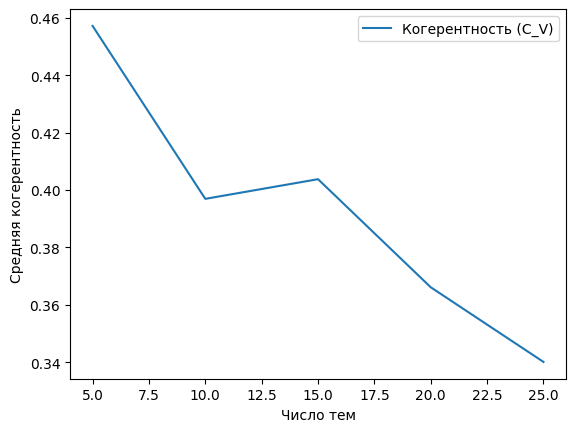

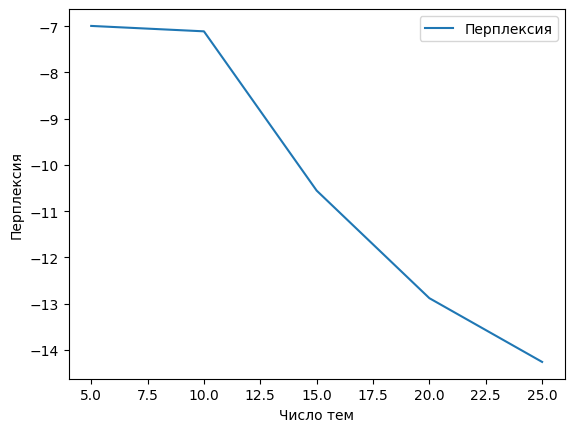

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

topics_list = [5, 10, 15, 20, 25]
coherences = []
perplexities = []

for num in tqdm(topics_list):
    lda = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=num, chunksize=50, update_every=1, passes=2)
    coherences.append(CoherenceModel(model=lda, texts=preprocessed_questions, dictionary=dictionary, coherence='c_v').get_coherence())
    perplexities.append(lda.log_perplexity(corpus))

# График когерентности
plt.plot(topics_list, coherences, label="Когерентность (C_V)")
plt.xlabel("Число тем")
plt.ylabel("Средняя когерентность")
plt.legend()
plt.show()

# График перплексии
plt.plot(topics_list, perplexities, label="Перплексия")
plt.xlabel("Число тем")
plt.ylabel("Перплексия")
plt.legend()
plt.show()



Судя по графику когерентности стоит выбрать 15 тем.

### Выполнение LDA на биграммах

In [24]:
# Создание биграмм из униграмм
bigram = Phrases(preprocessed_questions, min_count=5, threshold=10)

# Обработка текстов вопросов с биграммами
texts_bigrams = [bigram[q] for q in preprocessed_questions]

# Создание словаря и корпуса для биграмм:
dictionary_bigram = Dictionary(texts_bigrams)
corpus_bigram = [dictionary_bigram.doc2bow(text) for text in texts_bigrams]



In [25]:
# Выполнение LDA на биграммах:
num_topics = 10  # Количество тематик для биграмм
lda_model_bigram = LdaModel(corpus=corpus_bigram, id2word=dictionary_bigram, num_topics=num_topics, random_state=42)

In [28]:
# # Визуализация результатов с помощью LDAvis
# lda_vis_data_bigram = pyLDAvis.gensim_models.prepare(lda, corpus, dictionary)
# pyLDAvis.save_html(lda_vis_data_bigram, 'lda_bigram_visualization.html')

# # Путь к файлу HTML-визуализации LDAvis
# lda_bigram_visualization_path = 'lda_bigram_visualization.html'

# # Открываем и отображаем визуализацию LDA
# with open(lda_bigram_visualization_path, 'r') as f:
#     html_content = f.read()
#     display(HTML(html_content))

### Вычислим перплексию и когерентность для каждой модели:

In [29]:
perplexity = lda.log_perplexity(corpus)
perplexity_bigram = lda_model_bigram.log_perplexity(corpus_bigram)
print("Perplexity (Unigram):", perplexity)
print("Perplexity (Bigram):", perplexity_bigram)


Perplexity (Unigram): -14.258936834399806
Perplexity (Bigram): -8.854504879783862


In [30]:
from gensim.models import CoherenceModel

coherence_model_unigram = CoherenceModel(model=lda, texts=preprocessed_questions, dictionary=dictionary, coherence='u_mass') # так как с_v для биграмм не работает
coherence_unigram = coherence_model_unigram.get_coherence()
print("Coherence (Unigram):", coherence_unigram)

coherence_model_bigram = CoherenceModel(model=lda_model_bigram, texts=preprocessed_questions, dictionary=dictionary_bigram, coherence='u_mass') # так как с_v для биграмм не работает
coherence_bigram = coherence_model_bigram.get_coherence()
print("Coherence (Bigram):", coherence_bigram)


Coherence (Unigram): -3.5585739485943146
Coherence (Bigram): -3.186574519698569


Когерентность для обеих моделей (униграмм и биграмм) примерно одинаковая. Однако, сами значения -3.018 для униграмм и -3.007 для биграмм достаточно низкие, что может указывать на то, что модели не обнаруживают явных тематических связей в данных.

## Библиотека BigARTM
Попробуем построить модели с помощью библиотеки BigARTM. Тут и тут можно посмотреть на примеры использования библиотеки.

In [31]:
!apt-get --yes update
!apt-get --yes install git make cmake build-essential libboost-all-dev
!apt-get --yes install python-numpy python-pandas python-scipy
!wget https://bootstrap.pypa.io/get-pip.py
!python get-pip.py
!pip install protobuf tqdm wheel
!git clone --branch=stable https://github.com/bigartm/bigartm.git

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [634 kB]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Get:8 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [1,321 kB]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:10 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [1,568 kB]
Hit:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:12 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:13 http://security.

In [32]:
%cd bigartm

/content/bigartm


In [33]:
!mkdir build

In [34]:
%cd build

/content/bigartm/build


In [35]:
!cmake ..

CMake Deprecation Warning at CMakeLists.txt:1 (cmake_minimum_required):
  Compatibility with CMake < 3.5 will be removed from a future version of
  CMake.

  Update the VERSION argument <min> value or use a ...<max> suffix to tell
  CMake that the project does not need compatibility with older versions.


-- The C compiler identification is GNU 11.4.0
-- The CXX compiler identification is GNU 11.4.0
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Check for working C compiler: /usr/bin/cc - skipped
-- Detecting C compile features
-- Detecting C compile features - done
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Build type: Release
-- Looking for include file unistd.h
-- Looking for include file unistd.h - found
-- Found Boost: /usr/lib/x86_64-linux-gnu/cmake/Boost-1.74.0/BoostConfig.cmake (fou

In [36]:
!make

[  0%] Building CXX object 3rdparty/protobuf-3.0.0/cmake/CMakeFiles/libprotobuf.dir/__/src/google/protobuf/arena.cc.o
[  0%] Building CXX object 3rdparty/protobuf-3.0.0/cmake/CMakeFiles/libprotobuf.dir/__/src/google/protobuf/arenastring.cc.o
[  1%] Building CXX object 3rdparty/protobuf-3.0.0/cmake/CMakeFiles/libprotobuf.dir/__/src/google/protobuf/extension_set.cc.o
[  1%] Building CXX object 3rdparty/protobuf-3.0.0/cmake/CMakeFiles/libprotobuf.dir/__/src/google/protobuf/generated_message_util.cc.o
[  1%] Building CXX object 3rdparty/protobuf-3.0.0/cmake/CMakeFiles/libprotobuf.dir/__/src/google/protobuf/io/coded_stream.cc.o
[  2%] Building CXX object 3rdparty/protobuf-3.0.0/cmake/CMakeFiles/libprotobuf.dir/__/src/google/protobuf/io/zero_copy_stream.cc.o
[  2%] Building CXX object 3rdparty/protobuf-3.0.0/cmake/CMakeFiles/libprotobuf.dir/__/src/google/protobuf/io/zero_copy_stream_impl_lite.cc.o
[  2%] Building CXX object 3rdparty/protobuf-3.0.0/cmake/CMakeFiles/libprotobuf.dir/__/src/goog

In [37]:
!make install

[ 28%] Built target libprotobuf
[ 29%] Building CXX object 3rdparty/protobuf-3.0.0/cmake/CMakeFiles/libprotoc.dir/__/src/google/protobuf/compiler/java/java_file.cc.o
In file included from /usr/include/c++/11/set:60,
                 from /content/bigartm/3rdparty/protobuf-3.0.0/src/google/protobuf/compiler/java/java_file.cc:41:
/usr/include/c++/11/bits/stl_tree.h: In instantiation of ‘static const _Key& std::_Rb_tree<_Key, _Val, _KeyOfValue, _Compare, _Alloc>::_S_key(std::_Rb_tree<_Key, _Val, _KeyOfValue, _Compare, _Alloc>::_Const_Link_type) [with _Key = const google::protobuf::FieldDescriptor*; _Val = const google::protobuf::FieldDescriptor*; _KeyOfValue = std::_Identity<const google::protobuf::FieldDescriptor*>; _Compare = google::protobuf::compiler::java::{anonymous}::FieldDescriptorCompare; _Alloc = std::allocator<const google::protobuf::FieldDescriptor*>; std::_Rb_tree<_Key, _Val, _KeyOfValue, _Compare, _Alloc>::_Const_Link_type = const std::_Rb_tree_node<const google::protobuf::F

In [38]:
!pip install bigartm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 15.0 MB/s eta 0:00:00


In [39]:
!pip install python/bigartm*.whl

ERROR: bigartm*.whl is not a valid wheel filename.


In [40]:
import artm

In [41]:
artm.version()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'0.9.2'

In [42]:
artm.ARTM(num_topics=10).info

config {
  topic_name: "topic_0"
  topic_name: "topic_1"
  topic_name: "topic_2"
  topic_name: "topic_3"
  topic_name: "topic_4"
  topic_name: "topic_5"
  topic_name: "topic_6"
  topic_name: "topic_7"
  topic_name: "topic_8"
  topic_name: "topic_9"
  score_config {
    name: "^^^ItemsProcessedScore^^^"
    type: ScoreType_ItemsProcessed
    config: ""
  }
  pwt_name: "pwt"
  nwt_name: "nwt"
  num_document_passes: 10
  reuse_theta: false
  cache_theta: false
}
score {
  name: "^^^ItemsProcessedScore^^^"
  type: "N4artm5score14ItemsProcessedE"
}
processor_queue_size: 0
num_processors: 2